## Structure learning in decomposable graphical models

Fitting simulated Auto-regressive gaussian graphical model

In [1]:
SAVE_PLOTS = True
SAVE_LOC =  '/home/mo/Dropbox/Apps/Overleaf/decomposable_graphs/img/'

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import time
from parallelDG.graph import trajectory
import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.distributions.g_intra_class as gic
import parallelDG.auxiliary_functions as aux
from parallelDG.distributions import discrete_dec_log_linear as loglin
import parallelDG.mh_parallel as pdg
from networkx.drawing.nx_pydot import graphviz_layout
sns.set_style("whitegrid")
options = {
    "font_size": 8,
    "node_size": 100,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
def save_location(filename, loc = SAVE_LOC):
    if SAVE_PLOTS:
        plt.savefig(loc + filename + '.png', dpi = 300, bbox_inches='tight')
    else: 
        plt.show()

### Simulating AR(1-5) Gaussian graphical model

In [3]:
p = 50
sigma2 = 1.0
rho = 0.9
n = 100
delta = 5

Number of edges 85, number of nodes 50
loglikelihood 1592.785678


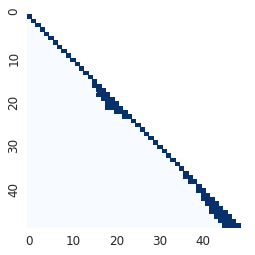

In [4]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=p, max_bandwidth=delta)
aux.plot_heatmap(nx.to_numpy_array(ar_graph), xticklabels=10, yticklabels=10)
ar_cov_mat = gic.cov_matrix(ar_graph, rho, sigma2)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(p), ar_cov_mat, n))
print('Number of edges {}, number of nodes {}'.format(ar_graph.size(), ar_graph.order()))
print('loglikelihood {:2f}'.format(pdg.ggm_loglikelihood(dataframe=ar_df,
                                                         graph=ar_graph,
                                                         graph_prior=['uniform'], 
                                                         delta=delta)))
save_location('ggm_true_graph_adj')

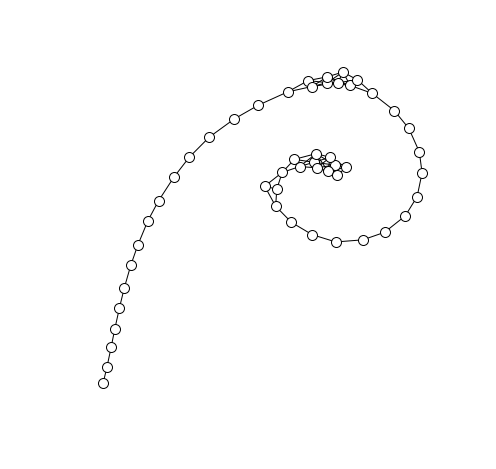

In [5]:
# Graph
plt.figure(figsize=(8,8))
pos = graphviz_layout(ar_graph, prog="fdp",)
nx.draw_networkx(ar_graph,pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
save_location('ggm_true_graph')

# Inference

## Parallel Metropolis-Hasting Junction-domain sampler

In [31]:
n_samples = 500000
randomize  = 100
graph_prior = ['uniform', 2.0, 4.0]
delta = 5.0
burnin = 200000
seed = 5

In [32]:
tic = time.time()
traj = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Parallel Metropolis-Hastings samples: 100%|██████████| 499999/499999 [01:38<00:00, 5088.91it/s] 


Total of 706001 updates, for an average of 1.41 per iteration or 7184.61updates/sec
Acceptance rate 0.0509
Time taken 99.98sec


### Graph number of edges

Setting up graph trajectories by mcmc_index
mcmc_index


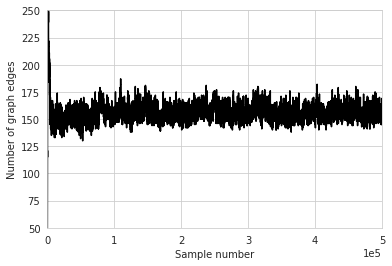

In [33]:
traj._size=None
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_index')
traj.size().plot(color = 'black')
size_mcmc_index = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ylim((50, 250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot')

Setting up graph trajectories by mcmc_subindex
mcmc_subindex


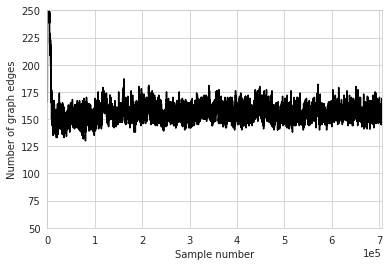

In [34]:
traj._size=None
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
traj.size().plot(color = 'black')
size_mcmc_subindex = list(traj._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ylim((50, 250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

save_location('ggm_size_traceplot_subindex')

### Progressive Acceptance ratio

In [35]:
## by mcmc index and subindex
## of the graph
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_index')
acc_mcmc_index = aux.acceptance_ratio(traj.trajectory)
traj.graph_updates = None
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
acc_mcmc_subindex = aux.acceptance_ratio(traj.trajectory)
## of the juncion tree
up = [0] * traj.n_updates
for x in traj.jt_updates: 
    up[x[1]] = 1
acc_jt_mcmc_subindex = np.mean(up, dtype=float), np.cumsum(up, dtype=float)/(np.array(range(len(up))) + 1.0)
print('Acceptance ratio  of junction tree updates{:2f}'.format(acc_jt_mcmc_subindex[0]))

Setting up graph trajectories by mcmc_index
mcmc_index
Acceptance ratio 0.059188
Setting up graph trajectories by mcmc_subindex
mcmc_subindex
Acceptance ratio 0.043848
Acceptance ratio  of junction tree updates0.050911


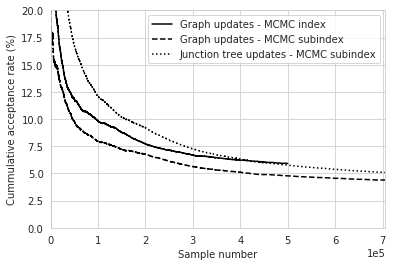

In [36]:
x = list(range(len(acc_mcmc_subindex[1])))
y = acc_mcmc_subindex[1]  * 100
z = acc_mcmc_index[1] * 100
u = acc_jt_mcmc_subindex[1] * 100
plt.plot(list(range(len(z))), z, color='black', label='Graph updates - MCMC index')
plt.plot(x, y, color='black', label='Graph updates - MCMC subindex', ls='--')
plt.plot(list(range(len(u))), u, color='black', label='Junction tree updates - MCMC subindex', ls = ':')
plt.ylim((0, 20))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

### Autocorrelation plot

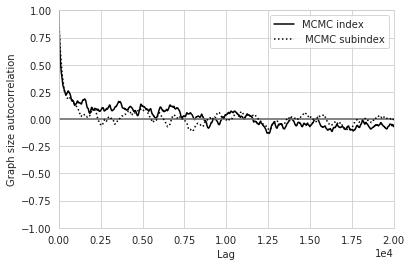

In [12]:
## Auto correlalation plot 
burnin = 50000
lag=20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'MCMC index', color = 'black', lag =lag)
aux.autocorrelation_plot(df['mcmc_subindex'], 
                                 label = ' MCMC subindex',
                                 color = 'black',
                                    ls = ':', lag = lag)
plt.legend()
plt.ylabel('Graph size autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')
#plt.show()

### Log-likelihood trace plot

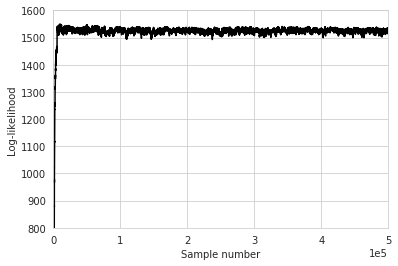

In [37]:
traj.log_likelihood().plot(color='black')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
plt.ylim((800, 1600))
save_location('ggm_loglikelihood_traceplot')

### Maximum A Posteriori Graph

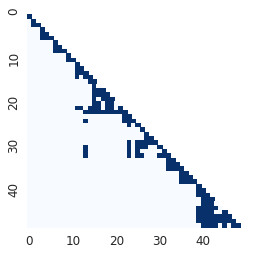

In [38]:
aux.plot_heatmap(nx.to_numpy_array(traj.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
save_location('ggm_est_map_graph')

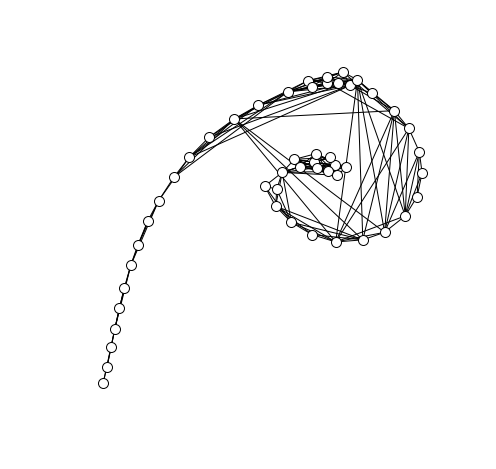

In [15]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

### Trace plot heatmap

In [16]:
emp=traj.empirical_distribution(burnin).heatmap()

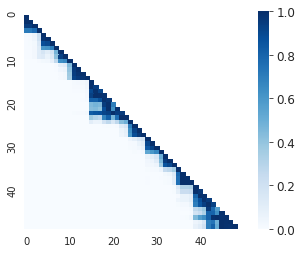

In [17]:
sns.set_style("whitegrid")
aux.plot_heatmap(emp, xticklabels=10, yticklabels=10 ,cbar = True)
save_location('ggm_est_heatmap')

### Most sampled graph

In [39]:
most_sampled = aux.most_sampled_graph(traj.trajectory[burnin:])
most_sampled

{'count': 731.0, 'g': <networkx.classes.graph.Graph at 0x7fbec685b190>}

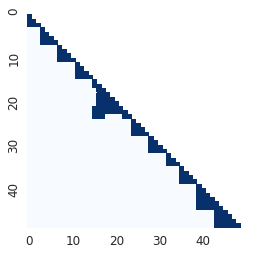

In [40]:
aux.plot_heatmap(nx.to_numpy_array(most_sampled['g']), xticklabels=10, yticklabels=10)
save_location('ggm_est_most_sampled_graph')

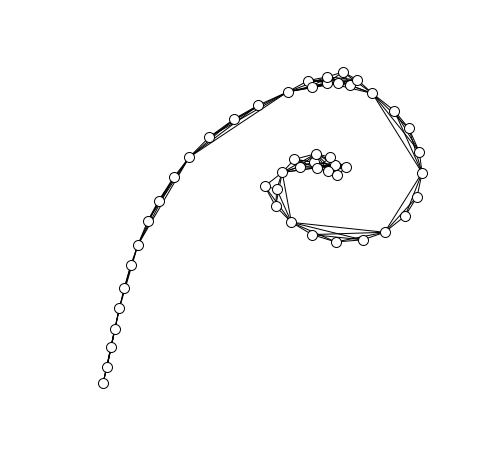

In [20]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(most_sampled['g'],pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()


# Single-move juntion-domain sampler

In [21]:
n_samples = 1000000
randomize  = 100
graph_prior = ['uniform', 2.0, 4.0]
delta = 5.0
burnin = 300000
sns.set_style("whitegrid")
tic = time.time()
seed = 2
traj_single = pdg.sample_trajectory_ggm(dataframe=ar_df, 
                                 n_samples=n_samples,
                                 randomize=randomize, 
                                 graph_prior = graph_prior,
                                 delta = delta, 
                                 seed = seed,
                                 single_move = True)
toc = time.time()
print('Time taken {:.2f}sec'.format(toc-tic))

Metropolis-Hastings samples: 100%|██████████| 999999/999999 [03:39<00:00, 4548.46it/s]

Total of 999802 updates, for an average of 1.00 per iteration or 4546.93updates/sec
Acceptance rate 0.0285
Time taken 219.91sec


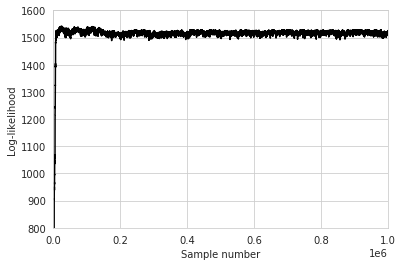

In [22]:
# Loglikelihood  trace plot
traj_single.log_likelihood().plot(color='black')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Log-likelihood')
plt.xlabel('Sample number')
plt.ylim((800,1600))
save_location('ggm_loglikelihood_traceplot_single_move')

Setting up graph trajectories by mcmc_index
mcmc_index


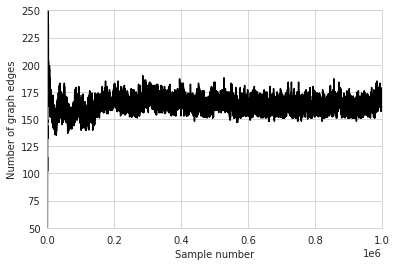

In [23]:
traj_single._size=None
traj_single.graph_updates = None
traj_single.set_graph_trajectories(index_type = 'mcmc_index')
traj_single.size().plot(color = 'black')
single_move_size_mcmc_index = list(traj_single._size)
plt.xlabel('Sample number')
plt.ylabel('Number of graph edges')
plt.ylim((50,250))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_size_traceplot_single_move')            


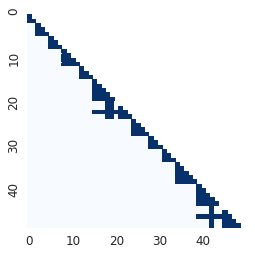

In [24]:
aux.plot_heatmap(nx.to_numpy_array(traj_single.maximum_likelihood_graph()), xticklabels=10, yticklabels=10)
#save_location('ggm_est_map_graph')

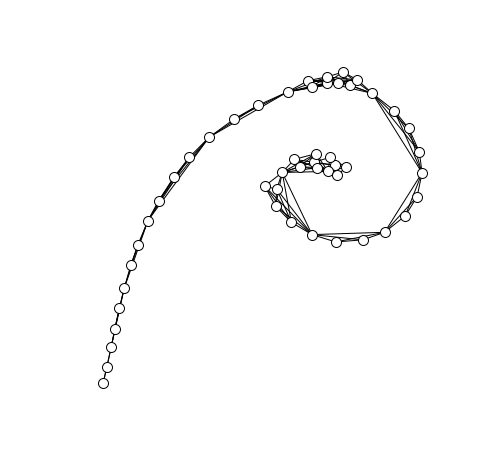

In [25]:
# Graph
plt.figure(figsize=(8,8))
nx.draw_networkx(traj_single.maximum_likelihood_graph(),pos=pos, with_labels=False, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [26]:
## by mcmc index and subindex
## of the graph
traj_single.graph_updates = None
traj_single.set_graph_trajectories(index_type = 'mcmc_index')
acc_single_move_mcmc_index = aux.acceptance_ratio(traj_single.trajectory)

Setting up graph trajectories by mcmc_index
mcmc_index
Acceptance ratio 0.026727


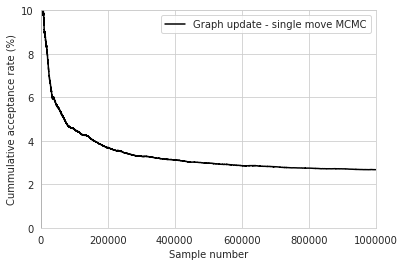

In [27]:
## plottting acceptance ratio
f = acc_single_move_mcmc_index[1] * 100
plt.plot(list(range(len(f))), f, color='black', label='Graph update - single move MCMC')
plt.ylim((0, 10))
plt.xlim((0, len(f)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
save_location('ggm_acceptance_ratio_single_move')

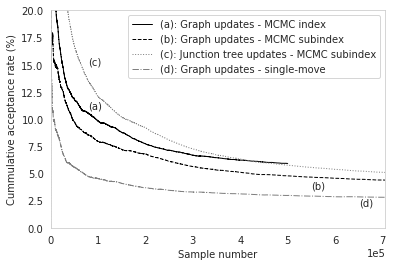

In [45]:
## Plotting joint acceptance ratio
x = list(range(len(acc_mcmc_subindex[1])))
y = acc_mcmc_subindex[1]  * 100
z = acc_mcmc_index[1] * 100
u = acc_jt_mcmc_subindex[1] * 100
lw = 1
ax = plt.plot(list(range(len(z))), z, color='black', label='(a): Graph updates - MCMC index',lw = lw)
plt.plot(x, y, color='black', label='(b): Graph updates - MCMC subindex', ls='--', lw = lw)
plt.plot(list(range(len(u))), u, color='grey', label='(c): Junction tree updates - MCMC subindex', ls = ':', lw=lw)
plt.plot(list(range(len(f))), f, color='grey',label='(d): Graph updates - single-move', ls = '-.', lw=lw)
plt.ylim((0, 20))
plt.xlim((0, max(x)))
plt.legend()
plt.xlabel('Sample number')
plt.ylabel('Cummulative acceptance rate (%)')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.annotate('(d)', xy=(650000,2))
plt.annotate('(b)', xy=(550000,3.6))
plt.annotate('(a)', xy=(80000,11))
plt.annotate('(c)', xy=(80000,15))
plt.grid(False)
save_location('ggm_acceptance_ratio_all')

### Autocorrelation plot

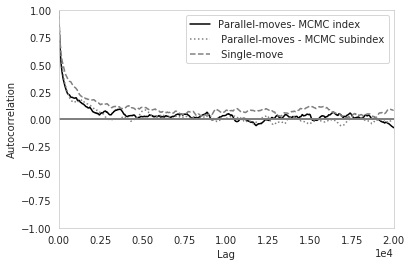

In [46]:
## Auto correlalation plot 
lag = 20000
df = pd.DataFrame({'mcmc_index': size_mcmc_index[-burnin:],
                   'mcmc_subindex': size_mcmc_subindex[-burnin:],
                    'mcmc_index_single_move': single_move_size_mcmc_index[-burnin:]})
aux.autocorrelation_plot(df['mcmc_index'], label = 'Parallel-moves- MCMC index', color = 'black', lag = lag)
aux.autocorrelation_plot(df['mcmc_subindex'], 
                                 label = ' Parallel-moves - MCMC subindex',
                                 color = 'grey',
                                    ls = ':', lag = lag)
aux.autocorrelation_plot(df['mcmc_index_single_move'], 
                                 label = ' Single-move',
                                 color = 'grey',
                                    ls = '--', lag = lag)
plt.legend()
plt.ylabel('Autocorrelation')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
save_location('ggm_autocorrelation')

In [30]:
acc_ratios_single = traj_single.dummy
total = [np.sum(x) for x in acc_ratios_single]
proposal = [x[2] for x in acc_ratios_single]
dt_single = pd.DataFrame({'total': total, 'proposal':proposal})
dt_single['likelihood'] = dt_single['total'] - dt_single['proposal']
dt_single['proposal_exp'] = np.exp(dt_single['proposal'])
dt_single['total_exp'] = np.exp(dt_single['total'])
dt_single['likelihood_exp'] = np.exp(dt_single['likelihood'])
